![](https://files.mdnice.com/user/23981/f283b615-03db-4fe7-865e-12defc92b8b2.png)

查询（自主提示）和键（非自主提示）之间的交互形成了注意力汇聚； 注意力汇聚有选择地聚合了值（感官输入）以生成最终的输出。 本节将介绍注意力汇聚的更多细节， 以便从宏观上了解注意力机制在实践中的运作方式。
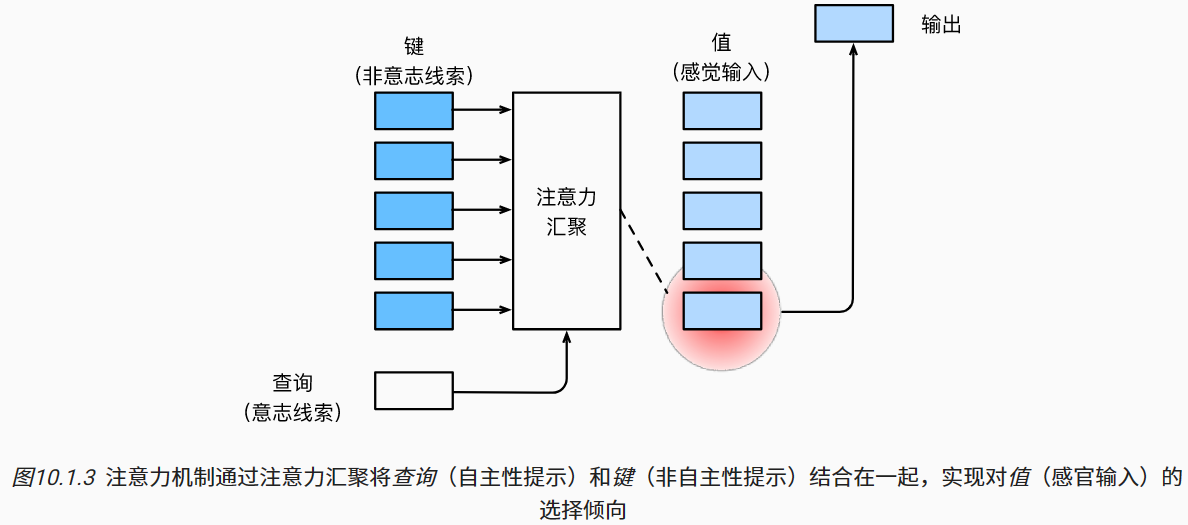

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # 排序后的训练样本

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
n_test

50

下面的函数将绘制所有的训练样本（样本由圆圈表示）， 不带噪声项的真实数据生成函数
（标记为“Truth”）， 以及学习得到的预测函数（标记为“Pred”）。

In [3]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

先使用最简单的估计器来解决回归问题。 基于平均汇聚来计算所有训练样本输出值的平均值：
$$
f(x)=\frac{1}{n} \sum_{i=1}^n y_i
$$
如下图所示，这个估计器确实不够聪明。 真实函数f（“Truth”）和预测函数（“Pred”）相差很大。
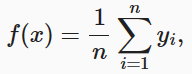

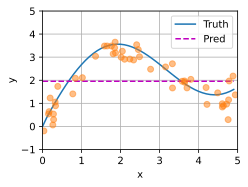

In [4]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

这行代码是使用 PyTorch 深度学习框架中的 `torch.repeat_interleave()` 函数将 `y_train.mean()` 的值按照指定次数复制，生成一个长度为 `n_test` 的张量 `y_hat`。

具体来说，`y_train.mean()` 是训练集标签 `y_train` 的均值，`n_test` 是测试集样本数量。通过 `torch.repeat_interleave()` 函数将 `y_train.mean()` 复制 `n_test` 次，就得到了一个长度为 `n_test` 的预测结果 `y_hat`，其中每个元素都等于 `y_train` 的均值，即：

```
y_hat = [y_train.mean(), y_train.mean(), ..., y_train.mean()]   # 共 n_test 个元素
```

这个预测结果相当于一个简单的基准模型，它认为测试集中所有样本的输出都是训练集标签的平均值。在实际应用中，我们可以将这个基准模型的性能作为其他更复杂模型的参考，判断它们的优劣程度。

# 不带参数的注意力汇聚

softmax函数：https://www.jianshu.com/p/78ae6dbfd20f

显然，平均汇聚忽略了输入xi。 于是Nadaraya (Nadaraya, 1964)和 Watson (Watson, 1964)提出了一个更好的想法， 根据输入的位置对输出yi进行加权：
$$
f(x)=\sum_{i=1}^n \frac{K\left(x-x_i\right)}{\sum_{j=1}^n K\left(x-x_j\right)} y_i
$$
其中x是查询，(xi,yi)是键值对。 比较 (10.2.4)和 (10.2.2)， 注意力汇聚是yi的加权平均。 将查询x和键xi之间的关系建模为 注意力权重（attention weight）α(x,xi)， 如 (10.2.4)所示， 这个权重将被分配给每一个对应值yi。 对于任何查询，模型在所有键值对注意力权重都是一个有效的概率分布： 它们是非负的，并且总和为1。

为了更好地理解注意力汇聚， 下面考虑一个高斯核（Gaussian kernel），其定义为：
$$
K(u)=\frac{1}{\sqrt{2 \pi}} \exp \left(-\frac{u^2}{2}\right)
$$
将高斯核代入 (10.2.4)和 (10.2.3)可以得到：
$$
\begin{aligned}
f(x) & =\sum_{i=1}^n \alpha\left(x, x_i\right) y_i \\
& =\sum_{i=1}^n \frac{\exp \left(-\frac{1}{2}\left(x-x_i\right)^2\right)}{\sum_{j=1}^n \exp \left(-\frac{1}{2}\left(x-x_j\right)^2\right)} y_i \\
& =\sum_{i=1}^n \operatorname{softmax}\left(-\frac{1}{2}\left(x-x_i\right)^2\right) y_i .
\end{aligned}
$$
在 (10.2.6)中， 如果一个键x越是接近给定的查询xi， 那么分配给这个键对应值yi的注意力权重就会越大， 也就“获得了更多的注意力”。

值得注意的是，Nadaraya-Watson核回归是一个非参数模型。 因此， (10.2.6)是 非参数的注意力汇聚（nonparametric attention pooling）模型。 接下来，我们将基于这个非参数的注意力汇聚模型来绘制预测结果。 从绘制的结果会发现新的模型预测线是平滑的，并且比平均汇聚的预测更接近真实。
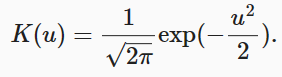
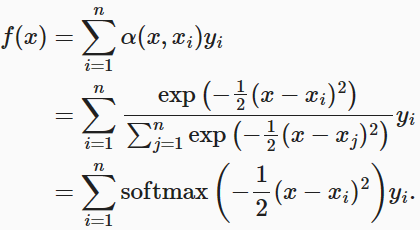
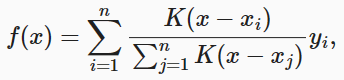

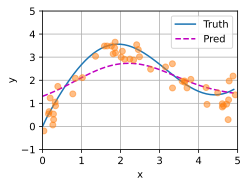

In [5]:
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

现在来观察注意力的权重。 这里测试数据的输入相当于查询，而训练数据的输入相当于键。 因为两个输入都是经过排序的，因此由观察可知“查询-键”对越接近， 注意力汇聚的注意力权重就越高。

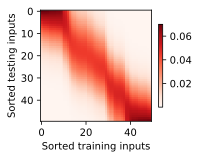

In [6]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

# 带参数的注意力汇聚

非参数的Nadaraya-Watson核回归具有一致性（consistency）的优点： 如果有足够的数据，此模型会收敛到最优结果。 尽管如此，我们还是可以轻松地将可学习的参数集成到注意力汇聚中。

例如，与 (10.2.6)略有不同， 在下面的查询x和键xi之间的距离乘以可学习参数w：
$$
\begin{aligned}
f(x) & =\sum_{i=1}^n \alpha\left(x, x_i\right) y_i \\
& =\sum_{i=1}^n \frac{\exp \left(-\frac{1}{2}\left((x-x_i\right)w)^2\right)}{\sum_{j=1}^n \exp \left(-\frac{1}{2}\left((x-x_j\right)w)^2\right)} y_i \\
& =\sum_{i=1}^n \operatorname{softmax}\left(-\frac{1}{2}\left((x-x_i\right)w)^2\right) y_i .
\end{aligned}
$$

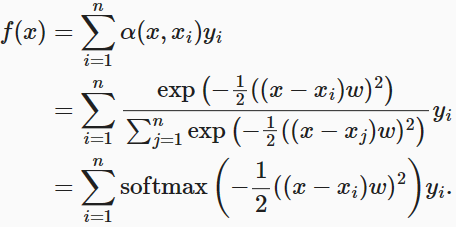

在注意力机制的背景中，我们可以使用小批量矩阵乘法来计算小批量数据中的加权平均值。

In [7]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

基于 (10.2.7)中的 带参数的注意力汇聚，使用小批量矩阵乘法， 定义Nadaraya-Watson核回归的带参数版本为：

In [14]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

接下来，将训练数据集变换为键和值用于训练注意力模型。 在带参数的注意力汇聚模型中， 任何一个训练样本的输入都会和除自己以外的所有训练样本的“键－值”对进行计算， 从而得到其对应的预测输出。

In [15]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

In [20]:
x_train.shape,X_tile.shape

(torch.Size([50]), torch.Size([50, 50]))

In [21]:
x_train,X_tile

(tensor([0.0344, 0.1523, 0.1667, 0.1947, 0.2629, 0.2788, 0.2829, 0.3230, 0.3324,
         0.3902, 0.7751, 0.8425, 1.0205, 1.3579, 1.5868, 1.6543, 1.7644, 1.8098,
         1.8460, 1.8591, 1.8696, 2.0155, 2.0448, 2.1027, 2.2376, 2.3336, 2.4118,
         2.4532, 2.4843, 2.7692, 3.1518, 3.3274, 3.3304, 3.5776, 3.6386, 3.6426,
         3.7018, 3.8007, 4.1912, 4.2145, 4.4890, 4.6069, 4.6080, 4.6360, 4.7171,
         4.7566, 4.7679, 4.7832, 4.8822, 4.9395]),
 tensor([[0.0344, 0.1523, 0.1667,  ..., 4.7832, 4.8822, 4.9395],
         [0.0344, 0.1523, 0.1667,  ..., 4.7832, 4.8822, 4.9395],
         [0.0344, 0.1523, 0.1667,  ..., 4.7832, 4.8822, 4.9395],
         ...,
         [0.0344, 0.1523, 0.1667,  ..., 4.7832, 4.8822, 4.9395],
         [0.0344, 0.1523, 0.1667,  ..., 4.7832, 4.8822, 4.9395],
         [0.0344, 0.1523, 0.1667,  ..., 4.7832, 4.8822, 4.9395]]))

训练带参数的注意力汇聚模型时，使用平方损失函数和随机梯度下降。

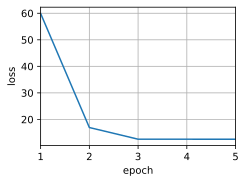

In [16]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

如下所示，训练完带参数的注意力汇聚模型后可以发现： 在尝试拟合带噪声的训练数据时， 预测结果绘制的线不如之前非参数模型的平滑。

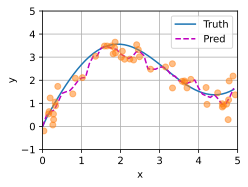

In [17]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

为什么新的模型更不平滑了呢？ 下面看一下输出结果的绘制图： 与非参数的注意力汇聚模型相比， 带参数的模型加入可学习的参数后， 曲线在注意力权重较大的区域变得更不平滑。

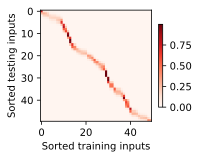

In [22]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

Query 代表单个输入数据的特征x_train

Keys 代表总的训练数据的特征x_train

Values 代表总的训练数据的标签y_train

# 注意力评分函数

高斯核指数部分可以视为注意力评分函数（attention scoring function）， 简称评分函数（scoring function）， 然后把这个函数的输出结果输入到softmax函数中进行运算。 通过上述步骤，将得到与键对应的值的概率分布（即注意力权重）。 最后，注意力汇聚的输出就是基于这些注意力权重的值的加权和。

从宏观来看，上述算法可以用来实现 图10.1.3中的注意力机制框架。 图10.3.1说明了 如何将注意力汇聚的输出计算成为值的加权和， 其中
表示注意力评分函数。 由于注意力权重是概率分布， 因此加权和其本质上是加权平均值。

![](https://files.mdnice.com/user/23981/113d67c1-7601-4c32-bedc-eb4ec7f8db12.png)

用数学语言描述, 假设有一个查询 $\mathbf{q} \in \mathbb{R}^q$ 和 $m$ 个“键一值”对 $\left(\mathbf{k}_1, \mathbf{v}_1\right), \ldots,\left(\mathbf{k}_m, \mathbf{v}_m\right)$, 其中 $\mathbf{k}_i \in \mathbb{R}^k, \mathbf{v}_i \in \mathbb{R}^v$ 。注意力汇聚函数 $f$ 就被表示成值的加权和:
$$
f\left(\mathbf{q},\left(\mathbf{k}_1, \mathbf{v}_1\right), \ldots,\left(\mathbf{k}_m, \mathbf{v}_m\right)\right)=\sum_{i=1}^m \alpha\left(\mathbf{q}, \mathbf{k}_i\right) \mathbf{v}_i \in \mathbb{R}^v
$$
其中查询 $\mathbf{q}$ 和键 $\mathbf{k}_i$ 的注意力权重（标量）是通过注意力评分函数 $a$ 将两个向量映射成标量, 再经过 softmax运算得到的：
$$
\alpha\left(\mathbf{q}, \mathbf{k}_i\right)=\operatorname{softmax}\left(a\left(\mathbf{q}, \mathbf{k}_i\right)\right)=\frac{\exp \left(a\left(\mathbf{q}, \mathbf{k}_i\right)\right)}{\sum_{j=1}^m \exp \left(a\left(\mathbf{q}, \mathbf{k}_j\right)\right)} \in \mathbb{R}
$$

正如上图所示，选择不同的注意力评分函数a会导致不同的注意力汇聚操作。 本节将介绍两个流行的评分函数，稍后将用他们来实现更复杂的注意力机制。

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

## 掩蔽的softmax函数

正如上面提到的，softmax操作用于输出一个概率分布作为注意力权重。 在某些情况下，并非所有的值都应该被纳入到注意力汇聚中。 例如，为了在 9.5节中高效处理小批量数据集， 某些文本序列被填充了没有意义的特殊词元。 为了仅将有意义的词元作为值来获取注意力汇聚， 可以指定一个有效序列长度（即词元的个数）， 以便在计算softmax时过滤掉超出指定范围的位置。 下面的masked_softmax函数 实现了这样的掩蔽softmax操作（masked softmax operation）， 其中任何超出有效长度的位置都被掩蔽并置为0。

In [2]:
def sequence_mask(X, valid_len, value=0):
    """Mask irrelevant entries in sequences.

    Defined in :numref:`sec_seq2seq_decoder`"""
    maxlen = X.size(1)  #获取序列长度
    # [None, :]为掩码添加一个新的维度，使其与输入序列X的维度匹配
    # valid_len[:, None]也为有效长度添加了一个新的维度，使其与输入序列X的维度匹配
    mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value    #选取序列X中对应掩码为True的元素，将选取的元素设置为指定的值value
    return X

In [7]:
torch.arange(4),torch.arange(4)[None,:],torch.arange(4)[None,:,None]

(tensor([0, 1, 2, 3]),
 tensor([[0, 1, 2, 3]]),
 tensor([[[0],
          [1],
          [2],
          [3]]]))

In [8]:
#@save
def masked_softmax(X,valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X：3D张量，valid_lens：1D或者2D张量
    if valid_lens is None:
        return nn.functional.softmax(X,dim=-1)
    else:
        shape=X.shape
        if valid_lens.dim()==1:
            valid_lens=torch.repeat_interleave(valid_lens,shape[1])
        else:
            valid_lens=valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的赋值替换，从而其softmax输出为0
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [9]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.5047, 0.4953, 0.0000, 0.0000],
         [0.4379, 0.5621, 0.0000, 0.0000]],

        [[0.2358, 0.4100, 0.3542, 0.0000],
         [0.4804, 0.2271, 0.2925, 0.0000]]])

In [10]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3356, 0.2935, 0.3709, 0.0000]],

        [[0.4821, 0.5179, 0.0000, 0.0000],
         [0.2581, 0.1900, 0.2742, 0.2776]]])

## 加性注意力

一般来说, 当查询和键是不同长度的矢量时, 可以使用加性注意力作为评分函数。给定查询 $\mathbf{q} \in \mathbb{R}^q$ 和键 $\mathbf{k} \in \mathbb{R}^k$, 加性注意力（additive attention）的评分函数为
$$
a(\mathbf{q}, \mathbf{k})=\mathbf{w}_v^{\top} \tanh \left(\mathbf{W}_q \mathbf{q}+\mathbf{W}_k \mathbf{k}\right) \in \mathbb{R}
$$
其中可学习的参数是 $\mathbf{W}_q \in \mathbb{R}^{h \times q} 、 \mathbf{W}_k \in \mathbb{R}^{h \times k}$ 和 $\mathbf{w}_v \in \mathbb{R}^h$ 。 如 (10.3.3)所示, 将查询和键连结 起来后输入到一个多层感知机（MLP）中, 感知机包含一个隐藏层, 其隐藏单元数是一个超参数 $h$ 。通过使用tanh作为激活函数, 并且禁用偏置项。

In [13]:
#@save
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self,key_size,query_size,num_hiddens,dropout,**kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k=nn.Linear(key_size,num_hiddens,bias=False)
        self.W_q=nn.Linear(query_size,num_hiddens,bias=False)
        self.w_v=nn.Linear(num_hiddens,1,bias=False)
        self.dropout=nn.Dropout(dropout)

    def forward(self,queries,keys,values,valid_lens):
        queries,keys=self.W_q(queries),self.W_k(keys)
        # 在维度扩展后，
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使用广播方式进行求和
        features=queries.unsqueeze(2)+keys.unsqueeze(1)
        features=torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores=self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)

在类 AdditiveAttention 中，$\mathbf{W}_q$ 和 $\mathbf{q}$ 以及 $\mathbf{W}_k$ 和 $\mathbf{k}$ 都是矩阵和向量的乘积，可以使用 PyTorch 中的 nn.Linear() 方法实现。具体来说，在 forward 方法中第一行代码：

```
queries, keys = self.W_q(queries), self.W_k(keys)
```

对 queries 和 keys 进行了线性变换，分别将其映射到 num_hiddens 维度中。其中 self.W_q 和 self.W_k 均为 nn.Linear() 实例，通过调用它们的 __call__() 方法实现矩阵和向量的乘积，并得到对应的结果 queries 和 keys。

因此，上述代码体现了 $\mathbf{W}_q\mathbf{q}$ 和 $\mathbf{W}_k\mathbf{k}$ 的计算过程。

用一个小例子来演示上面的AdditiveAttention类， 其中查询、键和值的形状为（批量大小，步数或词元序列长度，特征大小）， 实际输出为(2,1,20)、(2,10,2)和(2,10,4)。 注意力汇聚输出的形状为（批量大小，查询的步数，值的维度）。

In [14]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

尽管加性注意力包含了可学习的参数，但由于本例子中每个键都是相同的， 所以注意力权重是均匀的，由指定的有效长度决定。

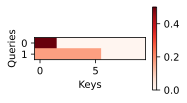

In [15]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)), xlabel='Keys', ylabel='Queries')

## 缩放点积注意力

使用点积可以得到计算效率更高的评分函数, 但是点积操作要求查询和键具有相同的长度 $d$ 。假设 查询和键的所有元素都是独立的随机变量, 并且都满足零均值和单位方差, 那么两个向量的点积的 均值为 0 , 方差为 $d$ 。为确保无论向量长度如何, 点积的方差在不考虑向量长度的情况下仍然是 1 , 我们再将点积除以 $\sqrt{d}$, 则缩放点积注意力 (scaled dot-product attention) 评分函数为:
$$
a(\mathbf{q}, \mathbf{k})=\mathbf{q}^{\top} \mathbf{k} / \sqrt{d}
$$
在实践中, 我们通常从小批量的角度来考虑提高效率, 例如基于 $n$ 个查询和 $m$ 个键一值对计算注意 力, 其中查询和键的长度为 $d$, 值的长度为 $v$ 。查询 $\mathbf{Q} \in \mathbb{R}^{n \times d}$ 、键 $\mathbf{K} \in \mathbb{R}^{m \times d}$ 和值 $\mathbf{V} \in \mathbb{R}^{m \times v}$ 的缩 放点积注意力是:
$$\operatorname{softmax}\left(\frac{\mathbf{Q K}^{\top}}{\sqrt{d}}\right) \mathbf{V} \in \mathbb{R}^{n \times v}$$
下面的缩放点积注意力的实现使用了暂退法进行模型正则化。

In [16]:
#@save
class DotProductAttention(nn.Module):
    def __init__(self,dropout,**kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout=nn.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self,queries,keys,values,valid_lens=None):
        d=queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries,keys.transpose(1,2))/math.sqrt(d)
        self.attention_weights=masked_softmax(scores,valid_lens)
        return torch.bmm(self.dropout(self.attention_weights),values)

为了演示上述的DotProductAttention类， 我们使用与先前加性注意力例子中相同的键、值和有效长度。 对于点积操作，我们令查询的特征维度与键的特征维度大小相同。

In [17]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

与加性注意力演示相同，由于键包含的是相同的元素， 而这些元素无法通过任何查询进行区分，因此获得了均匀的注意力权重。

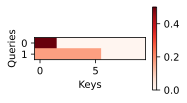

In [18]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)), xlabel='Keys', ylabel='Queries')